# Checkpoint 1 – Familiarize yourself with the challenge and data


In [2]:
from kaggle_secrets import UserSecretsClient
import ee
import io
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image

In [3]:
# Initialize OpenAI client
secret_label = "GOOGLE_API_KEY"
GOOGLE_API_KEY = UserSecretsClient().get_secret(secret_label)


In [6]:
import google.generativeai as genai

# Configure Gemini
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the model
model = genai.GenerativeModel("gemini-2.0-flash")

# Create the prompt and get response
prompt = "Say hello"
response = model.generate_content(prompt)

# Print the response text
print(response.text)

Hello! How can I help you today?



## Step 2: Learn how to use Google Earth Engine Python API

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it.

1. Run the code cell below; it will generate a link.
2. Copy the link and open it in a new browser tab.
3. Follow the on-screen prompts to authenticate and grant permissions.
   - Make sure to remember the name of your "Cloud Project"
4. A token will be generated. Copy this token.
5. Return to this cell and paste the token into the input box that appeared after running the cell and press **enter**.

In [7]:
# This might take a while; be patient :)
ee.Authenticate()

In [8]:
# Initialize the library.
ee.Initialize(project="policy-insights-456910") # replace this with your Cloud Project name

In [9]:
# Helper functions
def get_least_cloudy_s2_image(point_coords, start_date, end_date, cloud_filter_percentage, collection_id):
    """
    Filters the Sentinel-2 image collection for the least cloudy image
    over a given point and date range.

    Args:
        point_coords (list): A list of [longitude, latitude].
        start_date (str): The start date for filtering (YYYY-MM-DD).
        end_date (str): The end date for filtering (YYYY-MM-DD).
        cloud_filter_percentage (float): Maximum cloud pixel percentage.
        collection_id (str): The Earth Engine image collection ID.

    Returns:
        ee.Image: The least cloudy Sentinel-2 image or None if no image is found.
        ee.Geometry: The bounds of the buffered region around the point.
    """
    target_point = ee.Geometry.Point(point_coords)
    # Define the region of interest for the thumbnail by buffering and getting bounds
    region_bounds = target_point.buffer(BUFFER_RADIUS_METERS).bounds()

    collection = ee.ImageCollection(collection_id) \
        .filterBounds(target_point) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_filter_percentage)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') # Sort by cloud cover, ascending

    least_cloudy_image = collection.first()
    return least_cloudy_image, region_bounds

def get_image_thumbnail_url(image, region, dimensions, img_format, vis_params):
    """
    Generates a thumbnail URL for an Earth Engine image.

    Args:
        image (ee.Image): The Earth Engine image.
        region (ee.Geometry): The region for the thumbnail.
        dimensions (str): The dimensions (e.g., '800' for 800xN or Nx800).
        img_format (str): The image format (e.g., 'jpg', 'png').
        vis_params (dict): Visualization parameters including bands, min, max, gamma.

    Returns:
        str: The thumbnail URL.
    """
    # Apply visualization parameters to create an 8-bit RGB image
    # This is where gamma correction is applied before generating the thumbnail
    visualized_image = image.visualize(
        bands=vis_params['bands'],
        min=vis_params['min'],
        max=vis_params['max'],
        gamma=vis_params['gamma']
    )

    thumbnail_params = {
        'region': region,
        'dimensions': dimensions,
        'format': img_format
    }
    return visualized_image.getThumbURL(thumbnail_params)

def download_and_display_image(url, title):
    """
    Downloads an image from a URL and displays it with Matplotlib.

    Args:
        url (str): The URL of the image.
        title (str): The title for the plot.
    """
    try:
        response = urllib.request.urlopen(url)
        img_data = response.read()
        img = Image.open(io.BytesIO(img_data))

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()

        return img_data

    except urllib.error.URLError as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

In [10]:
# Configuration
# Target location (Latitude, Longitude)
COORDINATES = [-6.981918953145955, -58.36623265568083] # Lat, Lon for GEE Point
POINT_OF_INTEREST_NAME = 'Amazon Rainforest'
BUFFER_RADIUS_METERS = 3000  # Buffer around the point to define the region of interest

# Image collection and filtering parameters
IMAGE_COLLECTION_ID = 'COPERNICUS/S2_SR_HARMONIZED'
START_DATE = '2024-05-01'
END_DATE = '2025-05-01'
MAX_CLOUD_COVERAGE = 20  # Maximum cloud pixel percentage

# Visualization parameters for an RGB image
VIS_PARAMS = {
    'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands for true color
    'min': 0,
    'max': 3000, # Adjusted for Sentinel-2 SR typical reflectance values (scaled by 10000)
                # Max can be tuned (e.g., 0.3 * 10000 for reflectance, but 3000 is common for viz)
    'gamma': 1.3
}

# Thumbnail parameters
THUMBNAIL_DIMENSIONS = '800' # Width/height in pixels
THUMBNAIL_FORMAT = 'jpg'

In [11]:
# Note: GEE Point uses (longitude, latitude) order
gee_point_coords = [COORDINATES[1], COORDINATES[0]]

least_cloudy_image, region_for_thumbnail = get_least_cloudy_s2_image(
    gee_point_coords,
    START_DATE,
    END_DATE,
    MAX_CLOUD_COVERAGE,
    IMAGE_COLLECTION_ID
)

image_id = least_cloudy_image.id().getInfo()
print(f"Found image: {image_id}")

Found image: 20240720T141719_20240720T141713_T21MUN


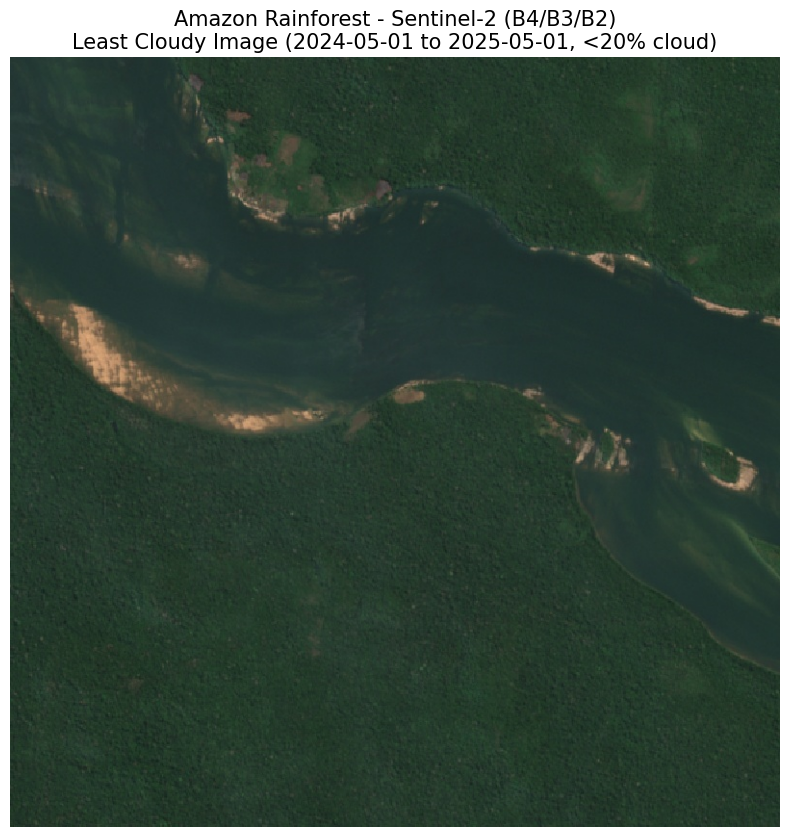

Original coordinates for Amazon Rainforest: [-6.981918953145955, -58.36623265568083] (Lat, Lon)


In [12]:
thumbnail_url = get_image_thumbnail_url(
    least_cloudy_image,
    region_for_thumbnail,
    THUMBNAIL_DIMENSIONS,
    THUMBNAIL_FORMAT,
    VIS_PARAMS
)

plot_title = f'{POINT_OF_INTEREST_NAME} - Sentinel-2 ({VIS_PARAMS["bands"][0]}/{VIS_PARAMS["bands"][1]}/{VIS_PARAMS["bands"][2]})\n' \
             f'Least Cloudy Image ({START_DATE} to {END_DATE}, <{MAX_CLOUD_COVERAGE}% cloud)'

image = download_and_display_image(
    thumbnail_url,
    plot_title,
)

print(f"Original coordinates for {POINT_OF_INTEREST_NAME}: {COORDINATES} (Lat, Lon)")

## Step 3: Combine what we have learnt

Now we ask ChatGPT about the image.


In [24]:
from IPython.display import Markdown

In [33]:

prompt = "Analyze the satelite image and describe surface features in plain English"
response = model.generate_content([prompt,thumbnail_url])
Markdown(response.text)

Okay, I've analyzed the satellite image you provided. Here's a plain English description of the surface features I see:

The image shows what appears to be a **predominantly desert landscape**. Here's a breakdown of what I'm seeing:

*   **Sandy Terrain:** A lot of the area is covered in what seems to be sand, possibly dunes in some regions. The texture is light brown and slightly uneven, suggesting wind action.

*   **Rocky Outcrops/Hills:** There are darker patches which could be rocky hills or outcrops. These areas have a less uniform texture than the sandy areas.

*   **Dry Riverbeds/Wadis:** Some faint, winding lines might represent dry riverbeds or wadis. These are areas where water might flow occasionally. They appear lighter in color compared to the surrounding land.

*   **Sparse Vegetation (Possibly):** There could be some very sparse vegetation, but it's hard to be certain. There are some very small green specks but it requires a closer inspection to see if this is vegetatation

*   **Little to No Water:** The image does not show any significant bodies of water, indicating an arid environment.